**Packages used:**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Overview

This notebook is a walkthrough of my process for predicting the CTR probabilities for the O' Reilley data challenge.

# Table of Contents

1. Data Summary
2. Evaluation Metric 
3. EDA
4. Train / Test  Split 
5. Feature Engineering
6. Feature Selection
7. Models
8. Conclusion 
9. Final Predictions

# Data Summary

In [2]:
data = pd.read_csv('data/sampled_training')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843502 entries, 0 to 843501
Data columns (total 24 columns):
id                  843502 non-null uint64
click               843502 non-null int64
hour                843502 non-null int64
C1                  843502 non-null int64
banner_pos          843502 non-null int64
site_id             843502 non-null object
site_domain         843502 non-null object
site_category       843502 non-null object
app_id              843502 non-null object
app_domain          843502 non-null object
app_category        843502 non-null object
device_id           843502 non-null object
device_ip           843502 non-null object
device_model        843502 non-null object
device_type         843502 non-null int64
device_conn_type    843502 non-null int64
C14                 843502 non-null int64
C15                 843502 non-null int64
C16                 843502 non-null int64
C17                 843502 non-null int64
C18                 843502 non-null int

In [4]:
data.describe()

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,8.435020e+05,843502.000000,8.435020e+05,843502.000000,843502.000000,843502.000000,843502.000000,843502.000000,843502.000000,843502.000000,843502.000000,843502.000000,843502.000000,843502.000000,843502.000000
mean,9.231625e+18,0.170271,1.410250e+07,1004.959553,0.293501,1.016934,0.330417,18560.262501,318.861537,60.286297,2077.663483,1.443956,217.741979,54155.776171,79.551913
std,5.325619e+18,0.375871,2.684486e+02,1.132949,0.515961,0.553377,0.854515,5007.778987,21.730624,47.965820,610.749820,1.323114,342.722108,49887.241496,66.999613
min,1.308118e+13,0.000000,1.410210e+07,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,1.000000
25%,4.622961e+18,0.000000,1.410222e+07,1005.000000,0.000000,1.000000,0.000000,16688.000000,320.000000,50.000000,1800.000000,0.000000,35.000000,-1.000000,23.000000
50%,9.238306e+18,0.000000,1.410251e+07,1005.000000,0.000000,1.000000,0.000000,20108.000000,320.000000,50.000000,2295.000000,2.000000,39.000000,100057.000000,52.000000
75%,1.384568e+19,0.000000,1.410272e+07,1005.000000,1.000000,1.000000,0.000000,21768.000000,320.000000,50.000000,2506.000000,3.000000,167.000000,100084.000000,91.000000
max,1.844669e+19,1.000000,1.410300e+07,1012.000000,7.000000,5.000000,5.000000,23836.000000,1024.000000,1024.000000,2729.000000,3.000000,1839.000000,100248.000000,253.000000


# Evaluation Metric

**Choosing log-loss as the evaluation metric:**

Since no evaluation metric was given for this problem, one must be defined before modeling in order to evaluate performance. Seeing as how the desired output is a probability and not a binary class, the best choice for the evaluation metric is one that is threshold independent. Additionally, to take into account the confidence of each prediction, log-loss seems like the best method to proceed. 

For this problem, **the goal will be to minimize log-loss**

# EDA 

Let's look at a few plots to get a sense of the data. 

## Clicks

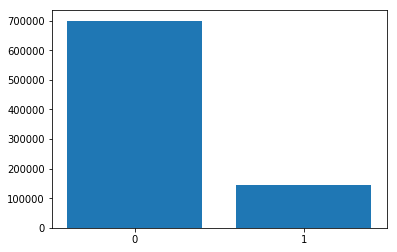

In [5]:
clicks = data.click.value_counts()

plt.bar(x=clicks.index, height=clicks.values)
plt.xticks(clicks.index, ('0', '1'))
plt.show()

The data is a bit unbalanced, depending on results, some oversampling could be helpful. 

## Banner Position

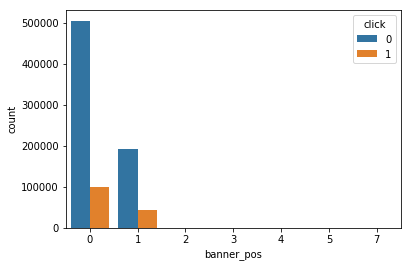

In [6]:
 ax = sns.countplot(x="banner_pos", hue="click", data=data)

There are only two major banner positions, the other 5 are negligible. 

## Hour 

In [7]:
data['24hr'] = data.hour.apply(lambda x: int(str(x)[-2:]))

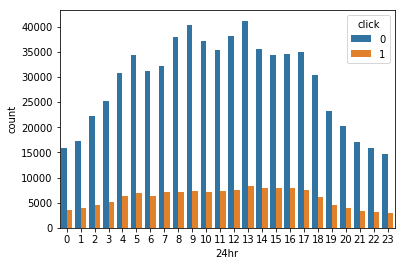

In [8]:
ax = sns.countplot(x="24hr", hue="click", data=data)

CTR pattern seems to be consistent throughout the hours. 

## Device Type 

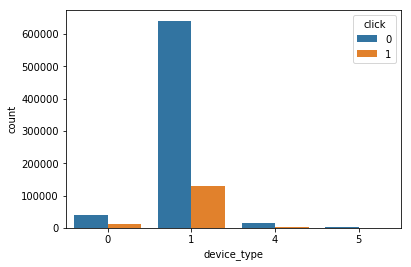

In [9]:
ax = sns.countplot(x="device_type", hue="click", data=data)

## Device Connection Type

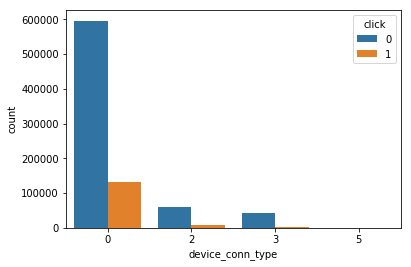

In [10]:
ax = sns.countplot(x="device_conn_type", hue="click", data=data)

# Train / Test Split

Before any modeling or feature engineering is done, a 90/10 train and validation split will be used to evaluate model performance. A 90/10 split was chosen instead of the traditional 80/20 due to the fairly large number of samples available. 

In [11]:
# 90/10 train test split
data_train, data_test = train_test_split(data, test_size=0.10)

# Feature Engineering

## Encode Categorical Columns to Numerical

All columns are categorical, let's encode them using the **weight of evidence approach**: 

$$v_{i} = log(\frac{\frac{p_{i}}{p}}{\frac{n_{i}}{n}})$$

where: 
* $p_{i}$ - number of positive instances attributed to categorical value 
* $p$ - number of positive instances 
* $n_{i}$ - number of negative instances attributed to categorical value 
* $n$ - number of negative instances 

In [12]:
categorical_variables = list(data_train.columns[2:])
print(f'There are {len(categorical_variables)} categorical columns')

There are 23 categorical columns


In [13]:
def woe_encoding(data_train, data_test, categorical_variables):
    '''
    Calculates weight of evidence encoding (woe) for categorical variables 
    Inputs:
        - df_train: training DataFrame to fit and transform encoding mapping 
        - df_test: test DataFrame to be transformed by encoding mapping 
        - categorical_variables: list of variables to transform from DataFrames 
    Outputs:
        - df_train: transformed DataFrame with woe encodings 
        - df_test: transformed DataFrame with woe encodings 
    '''
    # to get rid of SettingWithCopy warning 
    df_train = data_train.copy()
    df_test = data_test.copy()
    
    p = sum(df_train.click == 1)
    n = sum(df_train.click == 0)
    
    for cat in categorical_variables:
        # create dataframe with number of positives per unique value
        woe_df = df_train.groupby(by=cat, as_index=False).sum()[[cat, 'click']]
        woe_df.rename(columns={'click': 'sum'}, inplace=True)
        # merge dataframe with number of negatives per unique value
        count = df_train.groupby(by=cat, as_index=False).count()[[cat, 'click']]
        woe_df = woe_df.merge(count, how='left', on=cat)
        woe_df.rename(columns={'click': 'count'}, inplace=True)
        # calculate weight of evidence
        woe_df['woe'] = np.log((woe_df['sum'] / p) /
                               ((woe_df['count'] - woe_df['sum'])/ n + 1e-5) + 1e-5)
        # map categorical value to numerical encoding
        df_train.loc[:,cat] = df_train[cat].map(
            woe_df.set_index(keys=cat)['woe']).round(decimals=4)
        # apply same mapping based on training to test
        df_test.loc[:,cat] = df_test[cat].map(
            (woe_df.set_index(keys=cat)['woe'])).round(decimals=4)
        # there may be some nans if the test set does not have the value, let's fill it with the mean
        df_test[cat].fillna(value=woe_df['woe'].mean(), inplace=True)
    return df_train, df_test 

data_train, data_test = woe_encoding(data_train, data_test, categorical_variables)

Create X and Y for modeling:

In [14]:
x_train = data_train.drop(columns=['click', 'id'])
y_train = data_train.click
x_test = data_test.drop(columns=['click', 'id'])
y_test = data_test.click

# Feature Selection

Let's use the logistic regression model as a quick and data feature selector. This is naive in the sense that it doesn't not account for possible interaction effects, but it's quick:

In [15]:
# calculate test set loss for each feature
losses = []
for cols in x_train.columns:
    lr = LogisticRegression(solver='lbfgs').fit(
        x_train[cols].values.reshape(-1, 1), y_train)
    probs = lr.predict_proba(x_test[cols].values.reshape(-1, 1))
    losses.append(log_loss(y_test.values, probs))

Ranking each feature based on log-loss from single feature logistic regression model:

In [16]:
ranked_features = pd.DataFrame(
    {'features': list(x_train.columns), 'loss': losses}).sort_values(by='loss')
ranked_features

,features,loss
17,C17,0.421437
14,C14,0.422610
3,site_id,0.424148
4,site_domain,0.428346
21,C21,0.435873
6,app_id,0.439593
19,C19,0.441048
18,C18,0.441388
7,app_domain,0.445379
20,C20,0.447342


# Models

4 models were used to predict class probabilities: 

* Logistic Regression
* Gradient Boosting 
* Random Forest 
* Voting Classifier (Ensemble of the 3 above) 

## Logistic Regression

In [17]:
lr_loss_train = []
lr_loss_test = []

# test base model in order of ranked features 
for idx in range(len(ranked_features)):
    features = list(ranked_features['features'])[0:idx+1]
    # previous runs showed overfitting, set C value to 0.5 for stronger penalty
    lr = LogisticRegression(solver='lbfgs', max_iter=1000, C=.5).fit(
        x_train[features], y_train)
    # train loss 
    probs_train = lr.predict_proba(x_train[features])
    lr_loss_train.append(log_loss(y_train.values, probs_train))
    # test loss 
    probs_test = lr.predict_proba(x_test[features])
    lr_loss_test.append(log_loss(y_test.values, probs_test))

Plotting training and test loss across features:

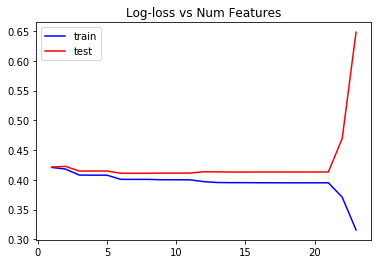

In [18]:
plt.plot(list(range(1,len(ranked_features)+1)),lr_loss_train, color='blue', label='train')
plt.plot(list(range(1,len(ranked_features)+1)),lr_loss_test, color='red', label='test')
plt.legend()
plt.title('Log-loss vs Num Features')
plt.show()

The best Logistic regression model is with the top 6 ranked features. The test loss is lowest at 6 features with a small gap between train and test loss. 

In [19]:
# best logistic regression model
lr_features = list(ranked_features['features'])[0:6]
best_lr = LogisticRegression(solver='lbfgs', max_iter=1000, C=.5).fit(
        x_train[lr_features], y_train)

In [20]:
# train loss 
probs_train = best_lr.predict_proba(x_train[lr_features])
print(f'Final LR train log loss {log_loss(y_train.values, probs_train):.4f}')
# test loss 
probs_test = best_lr.predict_proba(x_test[lr_features])
print(f'Final LR test log loss {log_loss(y_test.values, probs_test):.4f}')

Final LR train log loss 0.4007
Final LR test log loss 0.4110


## Gradient Boosting 

Let's try the Gradient Boosting model. A few things to curb overfitting: 
* `learning_rate` set to 0.01 
* `n_estimators` set to 200

In [21]:
xgb_loss_train = []
xgb_loss_test = []

# test base model in order of ranked features
for idx in range(15):
    features = list(ranked_features['features'])[0:idx+1]
    # learning rate 0.01 and n_estimators 200 chosen because previous iterations 
    # showed overfitting 
    xgb = GradientBoostingClassifier(
        learning_rate=0.01, n_estimators=200).fit(x_train[features], y_train)
    # train loss
    probs_train = xgb.predict_proba(x_train[features].values)
    xgb_loss_train.append(log_loss(y_train.values, probs_train))
    # test loss
    probs_test = xgb.predict_proba(x_test[features].values)
    xgb_loss_test.append(log_loss(y_test.values, probs_test))

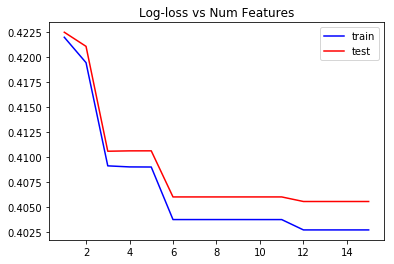

In [22]:
plt.plot(list(range(1,16)),xgb_loss_train, color='blue', label='train')
plt.plot(list(range(1,16)),xgb_loss_test, color='red', label='test')
plt.title('Log-loss vs Num Features')
plt.legend()
plt.show()

Let's use the XGB model with 6 features. Training and test loss is constant between 6-11 features, but the difference between training and test loss increases with 12+ features. 6 features is the simplest model with a reasonable bias and variance. 

In [23]:
# best xgb model
xgb_features = list(ranked_features['features'])[0:6]
best_xgb = GradientBoostingClassifier(learning_rate=0.01, n_estimators=200).fit(
    x_train[xgb_features].values, y_train)

In [24]:
# train loss 
probs_train = best_xgb.predict_proba(x_train[xgb_features].values)
print(f'Final XGB train log loss {log_loss(y_train.values, probs_train):.4f}')
# test loss 
probs_test = best_xgb.predict_proba(x_test[xgb_features].values)
print(f'Final XGB test log loss {log_loss(y_test.values, probs_test):.4f}')

Final XGB train log loss 0.4038
Final XGB test log loss 0.4060


## Random Forest

Random Forest model with `max_depth` set to 5 and `n_estimators` set to 100, previous iterations showed issue of overfitting

In [35]:
rf_loss_train = []
rf_loss_test = []

for idx in range(15):
    features = list(ranked_features['features'])[0:idx+1]
    # max_depth set to 5
    rf = RandomForestClassifier(n_estimators=100, max_depth = 5)
    rf.fit(x_train[features], y_train)
    # train loss 
    probs_train = rf.predict_proba(x_train[features].values)
    rf_loss_train.append(log_loss(y_train.values, probs_train))
    # test loss 
    probs_test = rf.predict_proba(x_test[features].values)
    rf_loss_test.append(log_loss(y_test.values, probs_test))

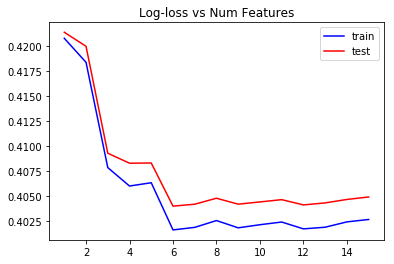

In [36]:
plt.plot(list(range(1,16)),rf_loss_train, color='blue', label='train')
plt.plot(list(range(1,16)),rf_loss_test, color='red', label='test')
plt.title('Log-loss vs Num Features')
plt.legend()
plt.show()

The best Random Forest model is with the top 6 ranked features.

In [37]:
# best rf model
rf_features = list(ranked_features['features'])[0:6]
best_rf = RandomForestClassifier(n_estimators=100, max_depth = 5).fit(
    x_train[rf_features].values, y_train)

In [38]:
# train loss 
probs_train = best_rf.predict_proba(x_train[rf_features].values)
print(f'Final RF train log loss {log_loss(y_train.values, probs_train):.4f}')
# test loss 
probs_test = best_rf.predict_proba(x_test[rf_features].values)
print(f'Final RF test log loss {log_loss(y_test.values, probs_test):.4f}')

Final RF train log loss 0.4016
Final RF test log loss 0.4041


## Voting Classifier

Voting Classifier with Logistic Regression, Gradient Boosting, and Random Forest models. Due to the differences in training data for each model, a custom voting classifier is used which takes an average of the predicted probabilities: 

In [39]:
models = [best_lr, best_xgb, best_rf]
features = [lr_features, xgb_features, rf_features]
weights = [1/3, 1/3, 1/3]

vc_train_probs = np.zeros((len(x_train),2))
vc_test_probs = np.zeros((len(x_test),2))

# calculate average train / test probabilities and final losses 
for idx in range(len(models)):
    vc_train_probs += weights[idx]*models[idx].predict_proba(x_train[features[idx]].values)
    vc_test_probs += weights[idx]*models[idx].predict_proba(x_test[features[idx]].values)

vc_loss_train = log_loss(y_train.values, vc_train_probs)
vc_loss_test = log_loss(y_test.values, vc_test_probs)

print(f'Voting classifier training loss is {vc_loss_train:.4f}')
print(f'Voting classifier val loss is {vc_loss_test:.4f}')

Voting classifier training loss is 0.4010
Voting classifier val loss is 0.4040


# Conclusion

Four different models were used: 
* Logistic Regression
* Gradient Boosting 
* Random Forest 
* Voting Classifier 

The **voting classifier** model is the best model with: 
* Training Log-loss: 0.4010
* Test Log-loss: 0.4040

Some areas that could be improved:
* Feature engineering - different methods of encoding could be tested, additional features could have been engineered 
* Hyper-parameter tuning - not much hyper-parameter tuning was done, this could be an area of improvement 
* Trying more models - try different classifiers and add them to the ensemble model for better performance 
* Data cleaning - checking for and removing outliers 

# Final Predictions

For final predictions, we'll use all of the data to train the models within the voting classifier:

First, we need to load the final test data and perform the same alterations as we did in the train set:

In [40]:
# load data and rename columns to match 
data_test_final = pd.read_csv('data/sampled_test', header=None)
column_names = list(data.columns)[:-1]
column_names.pop(1)
column_mapping = {i:column_names[i] for i in range(len(column_names))}
data_test_final.rename(columns=column_mapping, inplace=True)

# create 24 hr column 
data_test_final['24hr'] = data_test_final.hour.apply(lambda x: int(str(x)[-2:]))

# create encodings for full training set and final test set 
data_train_final, data_test_final = woe_encoding(data, data_test_final, categorical_variables)

Re-training the best models with the entire training data:

In [ ]:
# final logistic regression model
lr_final = LogisticRegression(solver='lbfgs', max_iter=1000, C=.5).fit(
        data_train_final[lr_features], data_train_final.click.values)

# final xgb model
xgb_final = GradientBoostingClassifier(learning_rate=0.01, n_estimators=200).fit(
    data_train_final[xgb_features].values, data_train_final.click.values)

# final rf model
rf_final = RandomForestClassifier(n_estimators=100, max_depth = 5).fit(
    data_train_final[rf_features].values, data_train_final.click.values)

Running final voting classifier:

In [ ]:
models = [lr_final, xgb_final, rf_final]

vc_train_probs = np.zeros((len(data_train_final),2))
vc_test_probs = np.zeros((len(data_test_final),2))

# calculate average train / test probabilities and final losses 
for idx in range(len(models)):
    vc_train_probs += weights[idx]*models[idx].predict_proba(data_train_final[features[idx]].values)
    vc_test_probs += weights[idx]*models[idx].predict_proba(data_test_final[features[idx]].values)
    
vc_loss_train = log_loss(data_train_final.click.values, vc_train_probs)    

print(f'Final training loss: {vc_loss_train:.4}')

**Saving final predictions:**

In [ ]:
np.savetxt("final_ctr_predictions.csv", vc_test_probs, delimiter=',')